In [202]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import os
import sqlite3
%matplotlib inline
import plotly.express as px
from plotly import graph_objs as go
import plotly.figure_factory as ff
from time import gmtime, strftime

# Model
# Compare the Logistic Regression Model V.S. Base Rate Model V.S. Random Forest Model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import tensorflow as tf
# Keras specific
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing import sequence
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

import toolkit as tool

import os

os.system('date')

ter 12 dez 2023 17:33:09 -03


0

### Objective

The data is for company X which is trying to control attrition. There are two sets of data: “Existing employees” and “Employees who have left”. Following attributes are available for every employee.
 - Satisfaction Level
 - Last evaluation
 - Number of projects
 - Average monthly hours
 - Time spent at the company
 - Whether they have had a work accident
 - Whether they have had a promotion in the last 5 years
 - Departments (column sales)
 - Salary
 - Whether the employee has left

In [203]:
# loading dataset.
df = pd.read_csv('../datasets/HR_COM1_tomodel.csv')
df.head(100)

,Emp ID,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,dept,salary
0,1,0.38,0.53,2,157,3,0,1,0,7,1
1,2,0.80,0.86,5,262,6,0,1,0,7,2
2,3,0.11,0.88,7,272,4,0,1,0,7,2
3,4,0.72,0.87,5,223,5,0,1,0,7,1
4,5,0.37,0.52,2,159,3,0,1,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.37,0.51,2,155,3,0,1,0,7,1
96,97,0.10,0.77,6,265,4,0,1,0,7,1
97,98,0.10,0.84,6,279,4,0,1,0,7,1
98,99,0.11,0.97,6,284,4,0,1,0,7,1


In [204]:
print(df['dept'].value_counts(normalize=True).map('{:.2%}'.format))

7    27.60%
9    18.13%
8    14.86%
0     8.18%
6     6.01%
5     5.72%
1     5.25%
2     5.11%
3     4.93%
4     4.20%
Name: dept, dtype: object


In [205]:
df.promotion.min()

0

In [206]:
shape_rows = df.shape[0]
shape_columns = df.shape[1]

print(f'Dataset rows = {shape_rows} and columns = {shape_columns}.')

Dataset rows = 14999 and columns = 11.


### X and y 

In [207]:
# Set the input X to the K-Means.
X = df.drop(columns=['turnover', 'Emp ID'])
y = df['turnover']

### Train and Test features

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123, stratify=y, shuffle = True)

### Modeling

In [209]:
modelname = 'model'

def metric_models(modelname, model, X_test, y_test, y_pred):
    acc   = round(accuracy_score(y_test,y_pred), 3)*100
    score = round(metrics.precision_score(y_test, y_pred, average='macro')*100, 2)
    mae   = round(mean_absolute_error(y_test, y_pred), 5)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(X_test)[::,1]
    auc = round((metrics.roc_auc_score(y_test, y_pred_proba))*100, 2)

    print(f'{modelname} model:')
    print(f"accuracy........:{acc}%")
    print(f'score...........:{score}')
    print(f"Mean Absolute Error: {mae}")
    print(f"Area under curve (AUC): {auc} %")

In [210]:
def plot_conf_matrix(y_test, y_pred):
    confusion_matrix1 = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix1).plot()
    plt.grid(False)
    plt.show()

#### CatBoostClassifier Model


In [211]:
# Create CatBoost classifier
#cat_model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', eval_metric='Accuracy')

from catboost import CatBoostClassifier, Pool

cat_model = CatBoostClassifier(
    iterations = 1000, # 1000 are ideal
    loss_function='MultiClass',
    bootstrap_type = "Bayesian",
    eval_metric = 'MultiClass',
    leaf_estimation_iterations = 100,
    random_strength = 0.5,
    depth = 7,
    l2_leaf_reg = 5,
    learning_rate=0.1,
    bagging_temperature = 0.5,
    thread_count=-1 # number of threads, setted all CPU cores
    #task_type = "GPU",
)

# Train the model
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
y_pred_cat = cat_model.predict(X_test)

print ("\n\n ---CatBoostClassifier Model---")
cat_roc_auc = roc_auc_score(y_test, y_pred_cat)
print ("CatBoost AUC = %2.2f" % cat_roc_auc)
print(classification_report(y_test, y_pred_cat))



 ---CatBoostClassifier Model---
CatBoost AUC = 0.99
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.98      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [212]:
metric_models('CatBoostClassifier', cat_model, X_test, y_test, y_pred_cat)

CatBoostClassifier model:
accuracy........:99.1%
score...........:98.85
Mean Absolute Error: 0.00867
Area under curve (AUC): 99.41 %


In [213]:
list_name_features = []
index = 1

for feat, importance in zip(X.columns, cat_model.feature_importances_):
    importance = round(importance, 2)
    print(f'{index} - feature: {feat}, importance: {importance} %')
    list_name_features.append(feat)
    index += 1

1 - feature: satisfaction, importance: 23.72 %
2 - feature: evaluation, importance: 14.81 %
3 - feature: projectCount, importance: 11.78 %
4 - feature: averageMonthlyHours, importance: 16.01 %
5 - feature: yearsAtCompany, importance: 17.65 %
6 - feature: workAccident, importance: 3.29 %
7 - feature: promotion, importance: 0.19 %
8 - feature: dept, importance: 7.54 %
9 - feature: salary, importance: 5.01 %


In [214]:
list_feat_importances = list(cat_model.feature_importances_)
dict_feat_importances = {}
#
i=0

for ilist in list_name_features:
    dict_feat_importances[ilist] = list_feat_importances[i] # porcentagem %
    print(f"{ilist}.......: {round(dict_feat_importances[ilist], 2)} %")
    i=i+1

satisfaction.......: 23.72 %
evaluation.......: 14.81 %
projectCount.......: 11.78 %
averageMonthlyHours.......: 16.01 %
yearsAtCompany.......: 17.65 %
workAccident.......: 3.29 %
promotion.......: 0.19 %
dept.......: 7.54 %
salary.......: 5.01 %


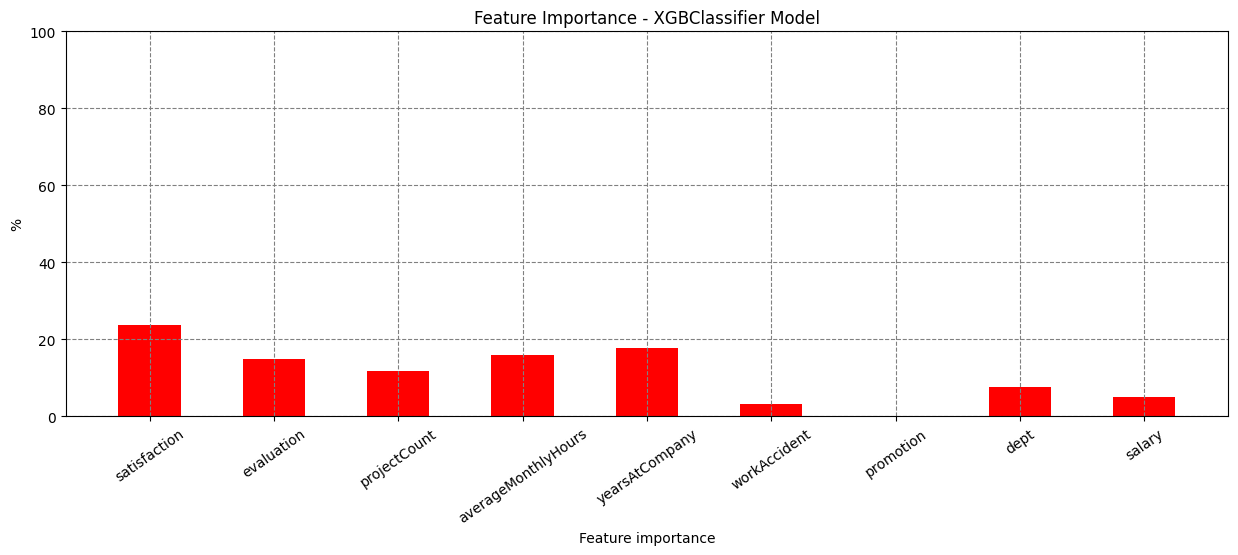

In [215]:
# feature importance
plt.figure(figsize=(15,5))
plt.bar(dict_feat_importances.keys(),dict_feat_importances.values(), width=.5, color='r')
plt.ylim(0,100)
plt.title("Feature Importance - XGBClassifier Model")
plt.ylabel("%")
plt.xlabel("Feature importance")
plt.xticks(rotation=35)
plt.grid(color='gray', linestyle='dashed')
plt.show()

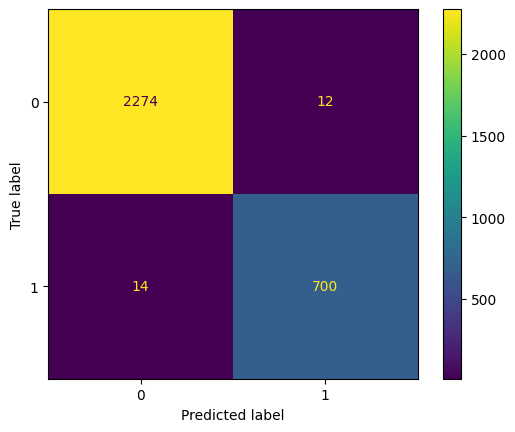

In [216]:
plot_conf_matrix(y_test, y_pred_cat)

In [217]:
os.system('date')

ter 12 dez 2023 17:34:59 -03


0